Class distribution after resampling:
1    13577
0    13577
Name: Corrected_Sentiment_Flag, dtype: int64
Training Accuracy: 0.7076305516682625
Accuracy: 0.7223993045494059
Sensitivity (True Positive Rate): 0.5542056074766355
AUC-ROC Score: 0.6537317474968911


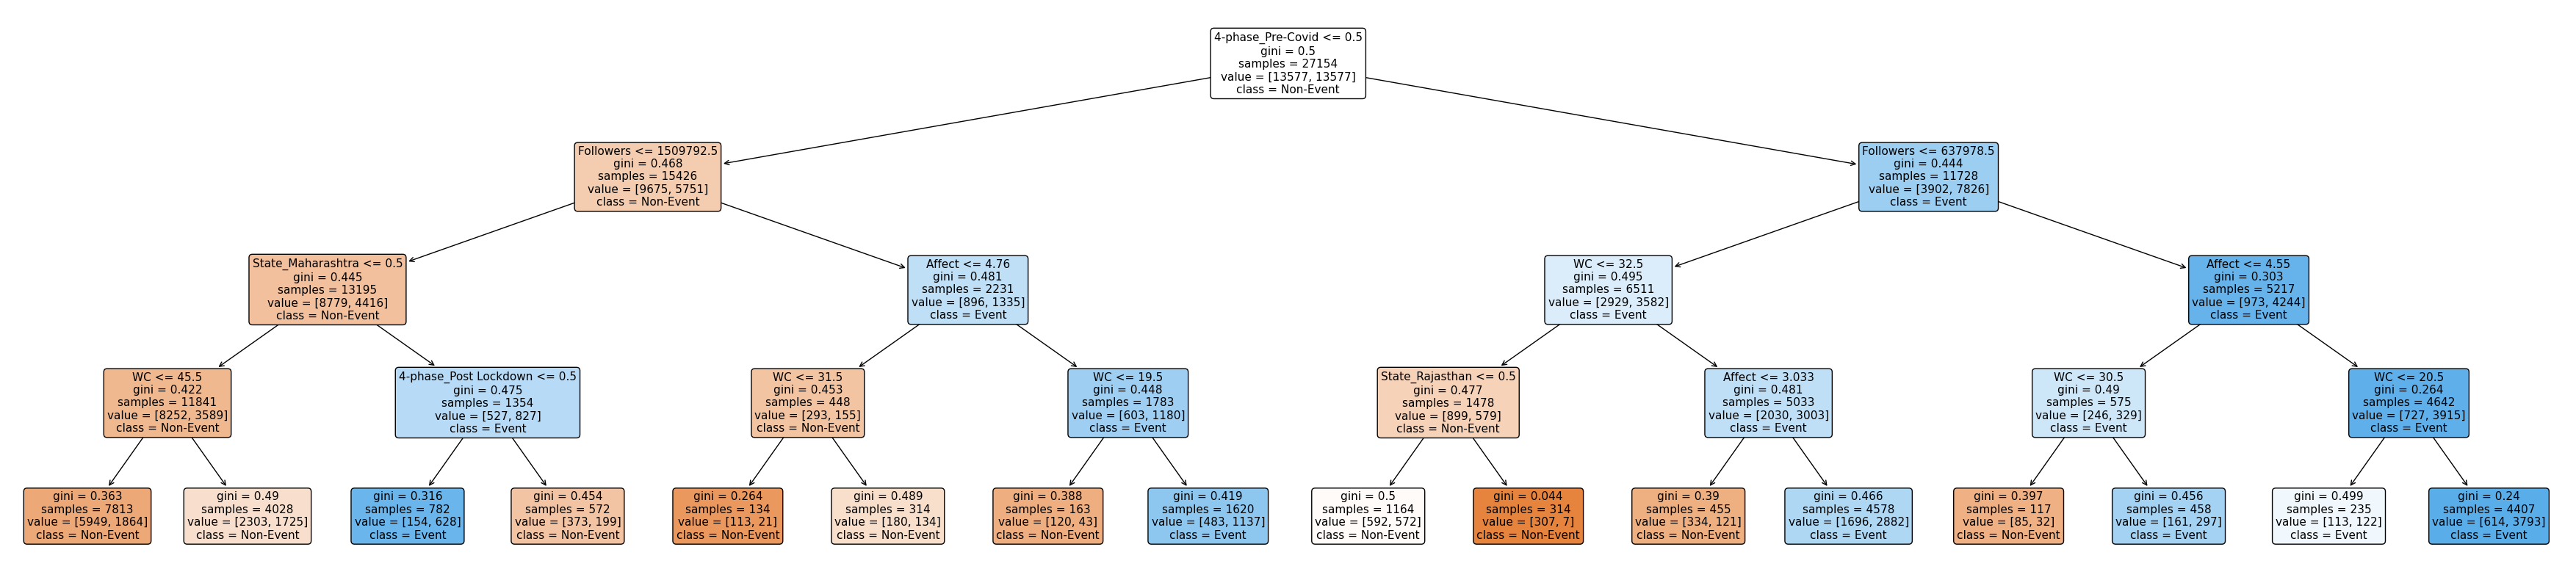

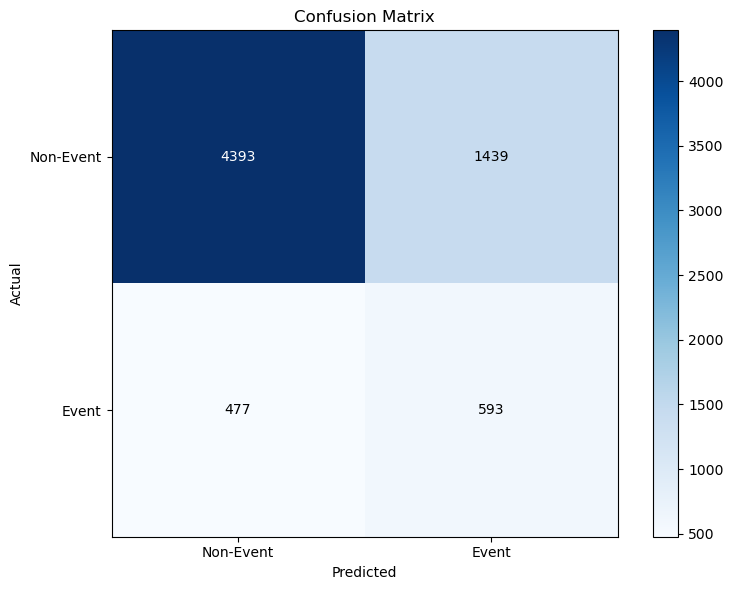

In [4]:
import pandas as pd
gba_data=pd.read_csv("Data LIWC 01 02 23.csv")
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt


# Separate feature columns (X) and target variable column (y)
X = gba_data.drop(columns=['DateDay', 'conversation_id', 'id', 'Date1', '3-Phase', 'Total_Sentiment','Corrected_Sentiment_Flag','Corrected_Sentiment',
                           'we.1', 'tentat', 'Drives', 'we','insight','emo_pos', 'emo_neg', 'cause', 'discrep', 'certitude', 'Sno', 'X', 'Positive', 'Negative' ])
y = gba_data['Corrected_Sentiment_Flag']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Identify categorical features
categorical_features_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

# Create preprocessor for numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ~X.columns.isin(X.columns[categorical_features_indices])),  # numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.columns[categorical_features_indices])  # categorical features
    ])

# Combine preprocessing with SMOTE-NC
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])



# Resample the training data using SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)

# Check class distribution after resampling
print("Class distribution after resampling:")
print(pd.Series(y_train_resampled).value_counts())

#Prepare for Classification
X_train_preprocessed_resampled = pipeline.fit_transform(X_train_resampled)

# Train CART decision tree classifier on the resampled data
dt_classifier = DecisionTreeClassifier(criterion="gini", splitter="best", random_state=42, max_depth=4) #min_samples_leaf = 1, min_impurity_decrease = 0.0005
dt_classifier.fit(X_train_preprocessed_resampled, y_train_resampled)

# Evaluate the classifier on the training set
y_train_pred = dt_classifier.predict(X_train_preprocessed_resampled)

# Calculate training accuracy
train_accuracy = accuracy_score(y_train_resampled, y_train_pred)

print("Training Accuracy:", train_accuracy)

# Preprocess the testing data
X_test_preprocessed = pipeline.transform(X_test)

# Evaluate the classifier on the testing set
y_pred = dt_classifier.predict(X_test_preprocessed)

accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
auc_roc_score = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Sensitivity (True Positive Rate):", sensitivity)
print("AUC-ROC Score:", auc_roc_score)

# Get the feature names from the preprocessor (one-hot encoding)
encoded_feature_names = pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(input_features=X.columns[categorical_features_indices])

# Concatenate the original feature names with the encoded feature names
all_feature_names = list(X.columns.drop(X.columns[categorical_features_indices])) + list(encoded_feature_names)

#plotting the tree
plt.figure(figsize=(45,10))
tree.plot_tree(dt_classifier, rounded=True, filled= True , label='all', impurity = True, class_names = ['Non-Event', 'Event'],  feature_names=all_feature_names, fontsize=11)     #class_names = Names of each of the target classes in ascending numerical order   
plt.show()

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes = ['Non-Event', 'Event']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Predicted')
plt.ylabel('Actual')

# Add text annotations
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
